<a href="https://colab.research.google.com/github/Taeho-Kim-0322/Deep_Learning_Start/blob/master/MISSION_%ED%86%A0%EB%8B%A5%ED%86%A0%EB%8B%A5%EB%B4%87_%EA%B9%80%ED%83%9C%ED%98%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MISSION : 토닥토닥봇 만들기💚









## #0. 실습 준비하기

먼저 구글 드라이브를 마운트하고, 1일차에서 코딩했던 전처리 코드가 들어있는 utils.py를 불러오겠습니다.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp "/content/gdrive/My Drive/NLP/utils.py" "/content"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


필요하실 수 있는 라이브러리들도 로딩했어요.   
<font color="blue"> 정상적인 코드 실행을 위해 아래 konlpy 설치 명령어 실행 후 [런타임]-[런타임 다시시작]을 클릭해주세요

In [2]:
!pip install konlpy
!pip install jpype1==0.7.0

import numpy as np
import tensorflow as tf

     |████████████████████████████████| 19.4MB 170kB/s 
     |████████████████████████████████| 92kB 13.0MB/s 
     |████████████████████████████████| 460kB 67.3MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
     |████████████████████████████████| 2.7MB 12.9MB/s 
  Found existing installation: JPype1 1.2.0
    Uninstalling JPype1-1.2.0:
      Successfully uninstalled JPype1-1.2.0


## #1. 데이터셋 불러오기

먼저 AI HUB에서 다운로드한 "웰니스_대화_스크립트_데이터셋.xlsx" 파일을 Colab에 업로드하겠습니다.   
좌측의 폴더 아이콘을 클릭하고, 업로드 아이콘을 통해 엑셀 파일을 업로드해주세요.


#### 1-1) 엑셀 파일 읽어오기
pandas 라이브러리를 이용해 엑셀 파일을 읽어오겠습니다.

In [3]:
"""MAKE DATASET"""
import json
import random
import pandas as pd
random.seed(1)
 
def isNaN(num):
    return num != num
 
EXCEL_FILE_NALE = "/content/웰니스_대화_스크립트_데이터셋.xlsx"
data = pd.read_excel(EXCEL_FILE_NALE)

#### 1-2) 엑셀 파일을 리스트로 변환
다음으로 엑셀 파일로부터 우리가 필요한 <카테고리> <사용자발화> <챗봇발화> 부분을 가지고오겠습니다.   
그런 다음 데이터를 train/ test로 나누고, 구글 드라이브에 저장합니다.   
아래 코드를 실행해주세요.

In [4]:
DATA = []
RESPONSE = {}
 
for i in range(len(data["구분"])):
  label = data["구분"][i]
  label_split = label.split("/")
  label_1 = "/".join(label_split[:2])
  sent = data["유저"][i]
  if label_1 != "모호함":
    DATA.append(["Sent_{}".format(i), sent, label_1, label])
    if label_1 in RESPONSE:  
      if not isNaN(data["챗봇"][i]): 
        RESPONSE[label_1].append(data["챗봇"][i])
    else: 
      if not isNaN(data["챗봇"][i]):  
        RESPONSE[label_1] = [data["챗봇"][i]]
 
"""random shuffle & make them into train/test set"""
labels = [dat[2] for dat in DATA]
from sklearn.model_selection import train_test_split
train, test = train_test_split(DATA, random_state = 2020, stratify = labels, test_size = 400)
 
with open("/content/gdrive/My Drive/NLP/Wellness_data_train.json","w") as f:
  f.write(json.dumps(train))
with open("/content/gdrive/My Drive/NLP/Wellness_data_test.json","w") as f:
  f.write(json.dumps(test))
with open("/content/gdrive/My Drive/NLP/Wellness_response.json","w") as f:
  f.write(json.dumps(RESPONSE))

#### 1-3) 데이터 살펴보기
그럼, 우리가 가진 학습 데이터가 어떻게 생겼는지 함께 살펴보겠습니다.   

In [5]:
import json
filename = "/content/gdrive/My Drive/NLP/Wellness_data_train.json"

with open(filename) as f:
  train = json.loads(f.read())
print("# of Train =", len(train))

# of Train = 4651


👉 총 4,651건의 (인풋 - 라벨) 쌍의 학습용 데이터가 있습니다.

In [6]:
print("Data Example")
for i in range(5):
  print(train[i])

Data Example
['Sent_4393', '뭔가 하루종일 이렇게 들뜬 기분이다 보니까 잠도 잘 안 와.', '증상/불면', '증상/불면']
['Sent_603', '아무한테나 화내고 그러지는 않아.', '감정/분노', '감정/분노']
['Sent_4224', '잠자리에 누워도 맨날 뒤척이고... 잠을 제대로 잘 수 있을 리가 없지.', '증상/불면', '증상/불면']
['Sent_3849', '5일 전에는 새벽에 일어나서 화장실을 가다가 순간적으로 정신을 잃었어.', '증상/기절', '증상/기절']
['Sent_666', '그냥 감정이입이 심하게 되고 불안감도 잘 느끼는 것 같아요.', '감정/불안감', '감정/불안감']


👉 학습 데이터의 첫 번째 다섯 개의 example들을 프린트해보았습니다.   
👉 리스트의 0번째에 문장_id, 1번째에 인풋 텍스트, 2번째에 정답 라벨이 있는 것을 확인할 수 있습니다.   
👉 3번째에 있는 것은 2번째에 있는 카테고리보다 세분화된 라벨로, 이번 태스크에서는 무시하셔도 좋습니다.

In [ ]:
import collections
train_counter = collections.Counter()
for dat in train:
  train_counter[dat[2]] += 1
print("라벨 개수:", len(train_counter), "\n")
print("*** LABEL 분포 ***")

for cnt in train_counter.most_common():
  print("{} : {} ({:.2f}%)".format(cnt[0], cnt[1], 100*cnt[1]/len(train)))

라벨 개수: 176 

*** LABEL 분포 ***
증상/불면 : 236 (5.07%)
배경/직장 : 152 (3.27%)
배경/남편 : 142 (3.05%)
감정/걱정 : 134 (2.88%)
배경/부모 : 125 (2.69%)
감정/힘듦 : 111 (2.39%)
배경/생활 : 107 (2.30%)
배경/성격 : 94 (2.02%)
감정/불안감 : 91 (1.96%)
감정/우울감 : 87 (1.87%)
감정/자살충동 : 87 (1.87%)
증상/무기력 : 87 (1.87%)
감정/부정적사고 : 86 (1.85%)
증상/피해망상 : 82 (1.76%)
증상/식욕저하 : 67 (1.44%)
배경/건강문제 : 65 (1.40%)
배경/남자친구 : 60 (1.29%)
증상/반복행동 : 59 (1.27%)
배경/학교 : 56 (1.20%)
배경/문제 : 55 (1.18%)
배경/음주 : 53 (1.14%)
감정/답답 : 51 (1.10%)
배경/대학 : 48 (1.03%)
배경/연애 : 47 (1.01%)
감정/짜증 : 46 (0.99%)
배경/경제적문제 : 46 (0.99%)
배경/사업 : 45 (0.97%)
증상/기억력저하 : 45 (0.97%)
증상/호흡곤란 : 44 (0.95%)
배경/여자친구 : 41 (0.88%)
치료이력/병원내원 : 40 (0.86%)
증상/두통 : 39 (0.84%)
증상/두근거림 : 37 (0.80%)
배경/친구 : 37 (0.80%)
배경/어린시절 : 35 (0.75%)
감정/화 : 35 (0.75%)
증상/환청 : 34 (0.73%)
배경/대인관계 : 33 (0.71%)
부가설명 : 33 (0.71%)
증상/은둔 : 32 (0.69%)
감정/심란 : 31 (0.67%)
증상/통증 : 31 (0.67%)
배경/취업 : 30 (0.65%)
배경/결혼 : 30 (0.65%)
배경/가족 : 30 (0.65%)
감정/후회 : 30 (0.65%)
감정/눈물 : 29 (0.62%)
배경/시댁 : 29 (0.62%)
배경/자녀 : 29 (0.6

👉 우리가 만들 NLU 텍스트 분류 모델이 어떤 카테고리를 예측해야 하는지 프린트해보았습니다.   
👉 각각의 라벨 이름과 그에 해당하는 데이터 개수와 그 비율이 나와 있습니다.   
👉 증상/불면과 같은 카테고리는 239개나 되는 예시 문장이 있지만, 원인/없음과 같은 카테고리는 5개밖에 문장이 없는 것을 볼 수 있습니다.

## #2. NLU 모델링

그럼, train 데이터셋을 사용해 176가지 감정 카테고리 분류 모델 학습을 시작해보세요!   

NLU 모델링을 위한 4가지 프로세스:   
토크나이징 - 인코딩 - 토큰 임베딩 -모델링

기억하고 계시지요:)?

참고로 각각의 스텝에서 결정하고, 코딩해야 할 것들은 다음과 같습니다. 
1. 토크나이징   
a. 어떤 단위의 토큰을 사용할 것인가? (형태소/ 글자)   
b. tokenize(sentence) 함수 정의하기   
c. 학습 데이터에 있는 문장 토크나이즈하기

2. 인코딩   
a. 단어사전 만들기   
  - 형태소 단위라면 -> CBOW 워드벡터 사용할지/ 처음부터 만들지 결정
  - 글자 단위라면 -> 학습 데이터에 등장한 글자들로 구성된 단어사전 만들기   

  b. text_encoder 만들기(TextEncoder 사용)   
  c. 토크나이징된 문장을 text_encoder를 사용해 인덱스로 변환하고, 모델 학습에 필요한 train_ids, train_labels 만들기 (create_cls_feature 함수 활용)   

--- 여기부터 모델링 ---
3. 임베딩   
4. 모델링   
a. 아키텍처 결정하기 (RNN? CNN? 하이퍼파라미터?)   
b. CBOW 워드 벡터를 사용하기로 했다면, Embedding Weight 초기화하기   
c. 모델 컴파일 (loss, optimizer, metrics)    
d. 모델 학습 (epoch 수 조절, EarlyStopping 등)



<font size=20> YOUR CODE HERE </font>

어려운 점
1. 전체적인 파이프라인을 짤 때, 흐름은 알겠음. 완벽한 이해가 안된 부분들이 있어서 기존 것을 그대로 따라하게됨..
2. 모델링간 하이퍼 파라미터 설정 부분은 특히 어려움..



In [33]:
'''
1. 토크나이징   
	a. 어떤 단위의 토큰을 사용할 것인가? (형태소/ 글자)
    → 형태소 Komoran()
	b. tokenize(sentence) 함수 정의하기
	c. 학습 데이터에 있는 문장 토크나이즈하기

2. 인코딩   
	a. 단어사전 만들기   
	  - 형태소 단위라면 -> CBOW 워드벡터 사용할지/ 처음부터 만들지 결정
	b. text_encoder 만들기(TextEncoder 사용)   
	c. 토크나이징된 문장을 text_encoder를 사용해 인덱스로 변환하고, 모델 학습에 필요한 train_ids, train_labels 만들기 (create_cls_feature 함수 활용)   
'''

from konlpy.tag import Komoran, Hannanum, Kkma, Okt
from utils import TextEncoder, create_cls_feature
import collections

#1-a
kmr = Komoran()

#1-b
def tokenize(lines):
  return kmr.morphs(lines)


#1-c(Tokenized_train), 2-a(new_vocab_list)
##단어사전 로딩
import numpy as np
with open("/content/gdrive/My Drive/NLP/vecs.tsv") as f:
  vecs = [v.strip() for v in f.readlines()]
final_embeddings = [v.split("\t") for v in vecs]
final_embeddings = np.array(final_embeddings, dtype="float32")
with open("/content/gdrive/My Drive/NLP/meta.tsv") as f:
  vocab_list = [v.strip() for v in f.readlines()]

tot_tokens = 0
oov_counter = collections.Counter()
Tokenized_train = []
for dat in train:
  sent = dat[1]
  tokenized_sent = tokenize(sent)
  tot_tokens += len(tokenized_sent)
  for word in tokenized_sent:
    if word not in vocab_list:
      oov_counter[word] += 1
  Tokenized_train.append([dat[0], tokenized_sent, dat[2]])

print("# OOV Tokens:", len(oov_counter))
print("{}/{} ({:.2f}%) are [UNK] in train tokens".format(sum(oov_counter.values()) , tot_tokens , 100*sum(oov_counter.values())/tot_tokens))

### Train 데이터에서 새로 발견한 토큰을 기존 단어 사전에 추가
most_common = oov_counter.most_common(len(oov_counter))
new_vocab_list = vocab_list.copy()
new_vocab_list.extend([v[0] for v in most_common])
print("\n# New Vocabs = {}".format(len(new_vocab_list)))


#2-b
text_encoder = TextEncoder(new_vocab_list)

#2-c
MAX_LEN = 50
train_ids, train_labels, label_map = create_cls_feature(Tokenized_train, text_encoder, max_seq_len=MAX_LEN)


from sklearn.model_selection import train_test_split
train_ids, val_ids, train_labels, val_labels = train_test_split(train_ids, train_labels , test_size=0.10, random_state=42, stratify=train_labels)

print("# Train={} # Val={}".format(len(train_ids), len(val_ids)))

# OOV Tokens: 471
838/74665 (1.12%) are [UNK] in train tokens
[('걔', 37), ('더라구', 20), ('어떡하지', 17), ('여치', 13), ('대요', 13), ('두근거리', 13), ('뒤척이', 12), ('갑갑', 12), ('아파서', 10), ('얼른', 8)]
[('버럭', 1), ('아차', 1), ('싱숭생숭하네요…', 1), ('대견', 1), ('돌덩이', 1), ('쭈꾸미를', 1), ('혹시나', 1), ('헷갈려요.', 1), ('근육통', 1), ('볼링공', 1)]

# New Vocabs = 70473
['[PAD]', '[UNK]', '하', '이', '.', '의', '는', '을', '다', 'ㄴ', '에', ',', '았', '은', '를', '었', '고', '되', '아', '에서', '가', '으로', '있', '들', '로', ')', '어', '(', '년', '과']
** 4651 examples processed
# Train=4185 # Val=466


In [ ]:
#모델 만들기

In [ ]:
'''

3. 임베딩   
4. 모델링   
	a. 아키텍처 결정하기 (RNN? CNN? 하이퍼파라미터?)   
	b. CBOW 워드 벡터를 사용하기로 했다면, Embedding Weight 초기화하기   
	c. 모델 컴파일 (loss, optimizer, metrics)    
	d. 모델 학습 (epoch 수 조절, EarlyStopping 등 )


176개 감정 카테고리로 분류함

'''


In [57]:
final_embeddings.shape

(70002, 128)

In [61]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense
 
tf.keras.backend.clear_session()
 
vocab_size = text_encoder.vocab_size # 단어사전 개수
embedding_dim = final_embeddings.shape[1] # 임베딩 차원
cnn_filters = [3,4,5,6] # 커널 사이즈
num_feature_map = 176 # 커널 사이즈당 사용할 필터의 개수
 
input_ = tf.keras.layers.Input(shape=(None,))
 
x =  Embedding(vocab_size, embedding_dim, mask_zero = True)(input_)
 
""" CNN filter 적용하기 """
result_cnns = []
for i, kernel in enumerate(cnn_filters):
  print("Apply CNN filter {}".format(kernel))
  temp = Conv1D(filters = num_feature_map,
                    kernel_size = kernel, activation='relu')(x)
  print(".. shape after Convolution:", temp.shape)
  temp = GlobalMaxPooling1D()(temp)
  print(".. shape after Max Pooling:", temp.shape)
  result_cnns.append(temp)
 
x = tf.keras.layers.concatenate(result_cnns, axis=-1)
 
""" 176개 분류하는 FCN 연결하기 """
labels = Dense(176, activation="softmax")(x)

Apply CNN filter 3
.. shape after Convolution: (None, None, 176)
.. shape after Max Pooling: (None, 176)
Apply CNN filter 4
.. shape after Convolution: (None, None, 176)
.. shape after Max Pooling: (None, 176)
Apply CNN filter 5
.. shape after Convolution: (None, None, 176)
.. shape after Max Pooling: (None, 176)
Apply CNN filter 6
.. shape after Convolution: (None, None, 176)
.. shape after Max Pooling: (None, 176)


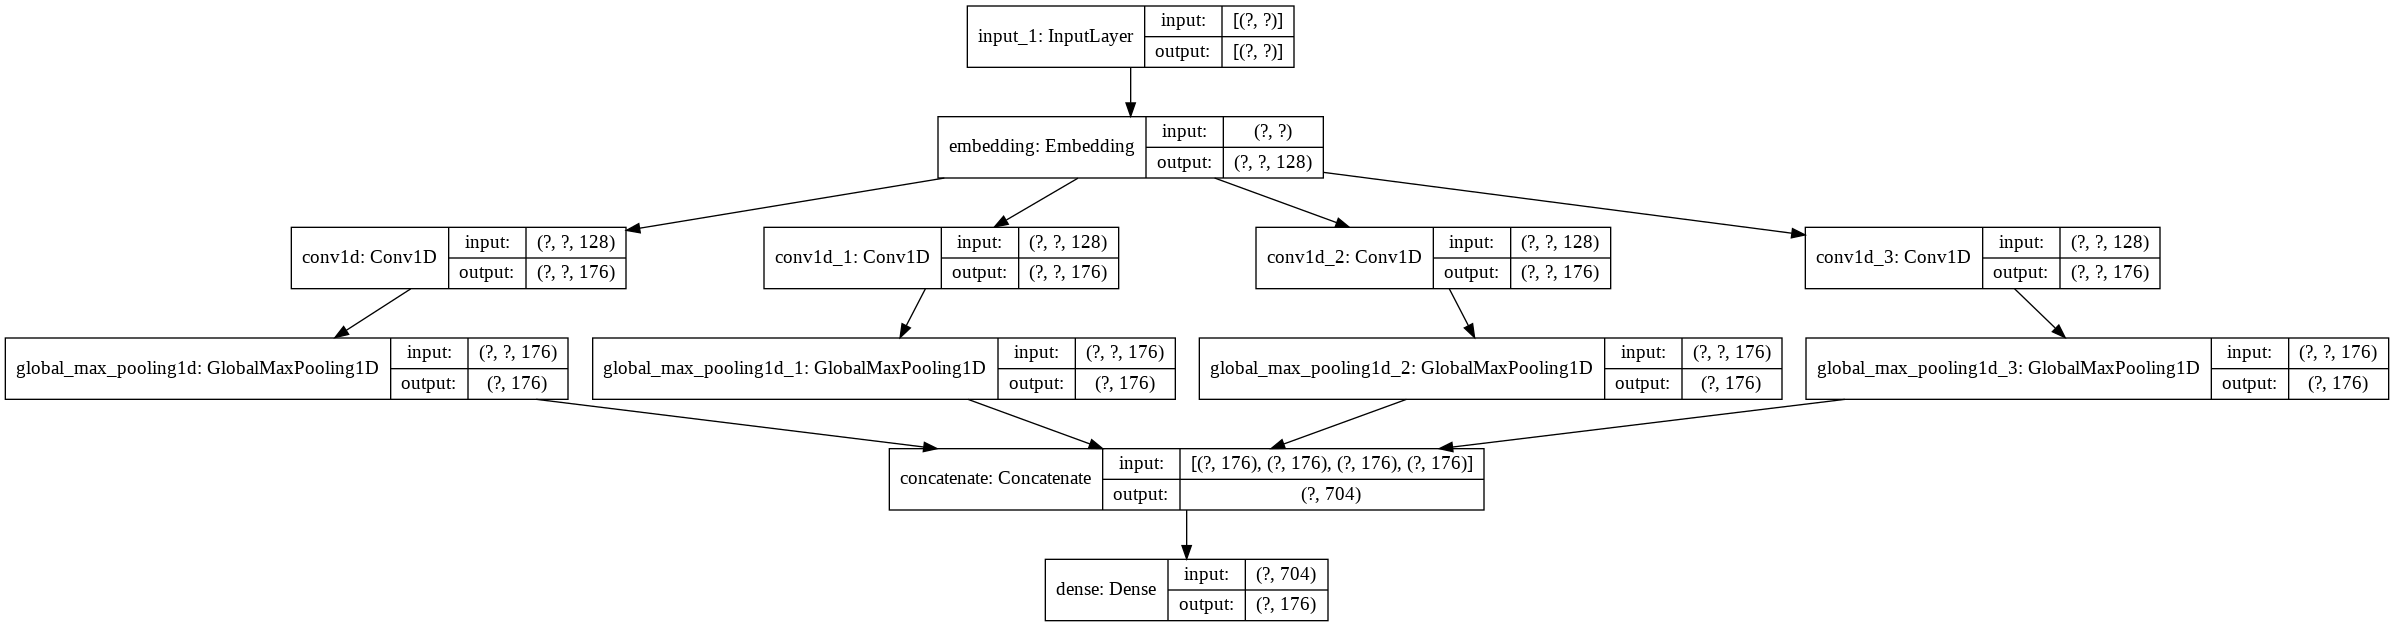

In [62]:
CNN = tf.keras.Model(inputs=input_, outputs = labels)
tf.keras.utils.plot_model(CNN , to_file='model.png', show_shapes=True)

In [63]:
CNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [64]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
 
num_epochs = 50
history = CNN.fit(train_ids, train_labels,
                       epochs=num_epochs, batch_size=100,
                    validation_data=(val_ids, val_labels), callbacks=[callback])


Epoch 1/50
42/42 [==============================] - 3s 66ms/step - loss: 4.8281 - accuracy: 0.0461 - val_loss: 4.6564 - val_accuracy: 0.0515
Epoch 2/50
42/42 [==============================] - 2s 54ms/step - loss: 4.4952 - accuracy: 0.1145 - val_loss: 4.3689 - val_accuracy: 0.1652
Epoch 3/50
42/42 [==============================] - 2s 54ms/step - loss: 4.0251 - accuracy: 0.2272 - val_loss: 3.9882 - val_accuracy: 0.2275
Epoch 4/50
42/42 [==============================] - 2s 54ms/step - loss: 3.5078 - accuracy: 0.3264 - val_loss: 3.6681 - val_accuracy: 0.3004
Epoch 5/50
42/42 [==============================] - 2s 54ms/step - loss: 2.9453 - accuracy: 0.4287 - val_loss: 3.3456 - val_accuracy: 0.3584
Epoch 6/50
42/42 [==============================] - 2s 54ms/step - loss: 2.3404 - accuracy: 0.5341 - val_loss: 3.0590 - val_accuracy: 0.4056
Epoch 7/50
42/42 [==============================] - 2s 54ms/step - loss: 1.7459 - accuracy: 0.6487 - val_loss: 2.8753 - val_accuracy: 0.4485
Epoch 8/50
42

## #3. 테스트 데이터에서의 성능 평가하기

In [65]:
filename = "/content/gdrive/My Drive/NLP/Wellness_data_test.json"

with open(filename) as f:
  test = json.loads(f.read())
print("# of Test =", len(test))

# of Test = 400


<font color="red"> test 데이터에 대해 학습 데이터 전처리에 사용한 tokenizer과 text_encoder를 사용해 test_ids와 test_labels를 만드세요

In [66]:
## 예시 코드
MAX_LEN = 50
Tokenized_text = []
for dat in test:
  Tokenized_text.append([dat[0], tokenize(dat[1]), dat[2]])

test_ids, test_labels, _ = create_cls_feature(Tokenized_text, text_encoder, max_seq_len=MAX_LEN, label_map = label_map)

** Start creating features using label map
{'증상/불면': 0, '감정/분노': 1, '증상/기절': 2, '감정/불안감': 3, '증상/두근거림': 4, '배경/건강문제': 5, '배경/취업': 6, '감정/우울감': 7, '배경/대인관계': 8, '배경/어린시절': 9, '감정/자살충동': 10, '감정/외로움': 11, '증상/자살시도': 12, '감정/걱정': 13, '배경/학업': 14, '증상/무기력': 15, '증상/식욕저하': 16, '일반대화': 17, '배경/결혼': 18, '상태/증상지속': 19, '배경/학교': 20, '감정/짜증': 21, '배경/부모': 22, '증상/두통': 23, '증상/피해망상': 24, '감정/자존감저하': 25, '배경/성격': 26, '증상/기억상실': 27, '배경/사업': 28, '감정/감정조절이상': 29, '배경/전연인': 30, '감정/불편감': 31, '배경/경제적문제': 32, '치료이력/병원내원': 33, '배경/친구': 34, '배경/가족': 35, '배경/여자친구': 36, '치료이력/검사': 37, '증상/어지러움': 38, '감정/부정적사고': 39, '감정/눈물': 40, '배경/시댁': 41, '증상/반복행동': 42, '감정/좌절': 43, '배경/자녀': 44, '감정/무력감': 45, '배경/사고': 46, '배경/직장': 47, '증상/기억력저하': 48, '증상/은둔': 49, '증상/환청': 50, '증상/이명': 51, '부가설명': 52, '감정/심란': 53, '감정/답답': 54, '감정/힘듦': 55, '감정/공허감': 56, '배경/남편': 57, '증상/반복사고': 58, '감정/무서움': 59, '감정/두려움': 60, '증상/피로': 61, '감정/속상함': 62, '감정/통제력상실': 63, '배경/생활': 64, '배경/종교': 65, '감정/자괴감': 66, '증상/환각': 67, '배경/음주': 68, '배경/대학

<font color="red"> test_ids를 인풋으로 받아 predictions를 생성하는 make_prediction 코드입니다.   
필요한 경우, 수정한 후 아래의 코드를 실행해보세요!

In [67]:
def make_prediction(test_ids):
  
  # model.predict 함수를 통해 확률값 받아오기
  scores = CNN.predict(test_ids)
  
  # 확률값이 가장 높은 카테고리로 분류하기
  predictions = np.argmax(scores, axis=1)

  return scores , predictions

In [68]:
def SCORE(predictions, ground_truth):
  print("TEST SET ACCURACY: {:.2f}".format(sum(predictions == ground_truth) / len(predictions)))
  print("-"*80)
  label_reverse = {v:k for k, v in label_map.items()}
  for i in range(len(predictions)):
    if predictions[i] != ground_truth[i]:
      print("🥺: {}".format(test[i][1]))
      print("-> 👩‍⚕️: {} 🤖: {}".format( label_reverse[ground_truth[i]], label_reverse[predictions[i]]), "\n")
      

In [69]:
scores, predictions = make_prediction(test_ids)

SCORE(predictions, test_labels)

TEST SET ACCURACY: 0.47
--------------------------------------------------------------------------------
🥺: 저는 이제 망했어요…
-> 👩‍⚕️: 감정/좌절 🤖: 내원이유/상담 

🥺: 스테로이드를 먹으니까 불면이 더 심해진 것 같아.
-> 👩‍⚕️: 증상/불면 🤖: 증상/폭식 

🥺: 이상하게 사고도 자꾸 생기는 것 같고…
-> 👩‍⚕️: 배경/사고 🤖: 감정/힘듦 

🥺: 나도 근속을 좀 해보고 싶다.
-> 👩‍⚕️: 배경/직장 🤖: 증상/무기력 

🥺: 2년정도 지나니까 빈털터리가 되있었어요.
-> 👩‍⚕️: 배경/경제적문제 🤖: 증상/기절예기 

🥺: 안심이 안 된다…
-> 👩‍⚕️: 감정/불안감 🤖: 자가치료/심리조절 

🥺: 가만히 있어도 떨리고… 심장 뛰는 소리가 막 들려요.
-> 👩‍⚕️: 증상/가슴떨림 🤖: 증상/두근거림 

🥺: 진짜 너무 마려워서 급하게 뛰어 들어갔는데 사람이 있는 거야.
-> 👩‍⚕️: 배경/문제 🤖: 감정/괴로움 

🥺: 밤에는 사람이 적으니까… 그나마 다닐 만한 것 같아.
-> 👩‍⚕️: 증상/대인기피 🤖: 감정/부정적사고 

🥺: 최근에 이직을 했어요.
-> 👩‍⚕️: 배경/직장 🤖: 배경/취업 

🥺: 내가 몸이 말을 안 들어서 운동도 관뒀는데 관둔 후에도 몸이 말썽이니까…
-> 👩‍⚕️: 배경/건강문제 🤖: 증상/악몽 

🥺: 지난 번에는 집 오는 길을 까먹어서 인터넷에 검색해서 왔어요.
-> 👩‍⚕️: 증상/기억력저하 🤖: 배경/생활 

🥺: 처음엔 분위기가 좋았는데, 고모님이 입을 열면서 점점 엉망진창으로 변했어요.
-> 👩‍⚕️: 배경/가족 🤖: 배경/전연인 

🥺: 어릴 때부터 옷을 입으면 갑갑했어.
-> 👩‍⚕️: 배경/문제 🤖: 감정/답답 

🥺: 처음부터 잘해주든가…
-> 👩‍⚕️: 감정/화 🤖: 감정/모호함 

🥺: 원래 마른 편이었는데..요즘 폭식을 심하게 해요.
-> 👩‍⚕️: 증상/폭식 🤖: 배경/성격 

🥺: 

## #4. Inference 실행하기

완성된 NLU 모델을 사용해 입력 문장에 대해 답변을 리턴하는 ROBOT_DOCTOR 함수를 직접 실행해보세요!

In [70]:
filename = "/content/gdrive/My Drive/NLP/Wellness_response.json"
with open(filename) as f:
  RESPONSE = json.loads(f.read())

In [71]:
import random
def ROBOT_DOCTOR(sentence, label_map=label_map):
  reverse_label = {v:k for k, v in label_map.items()}
  # 1. tokenizer로 문장 파싱
  parsed_sent = tokenize(sentence)
  input_id1 = []

  # 2. vocab_dict를 이용해 인덱스로 변환
  input_id1 = text_encoder.convert_tokens_to_ids(parsed_sent)
  
  # 단일 문장 추론이기 때문에 패딩할 필요가 없음
  input_id = np.array([input_id1])
  score, prediction = make_prediction(input_id)
  prediction = np.argmax(score[0])
  pred_label = reverse_label[prediction]
  

  print("🥺:", sentence)
  print(" -> 추론한 의도: {} ({:.2f}%)\n".format(pred_label , 100*score[0][prediction]))
  print("💚{}".format(random.choice(RESPONSE[pred_label])))  

In [72]:
ROBOT_DOCTOR("요즘 일이 너무 힘들오...")

🥺: 요즘 일이 너무 힘들오...
 -> 추론한 의도: 감정/힘듦 (87.89%)

💚그런 일이 있으셨군요. 조금씩 나아질 거라고 믿어요.


In [73]:
ROBOT_DOCTOR("사람 상대하는 것도 귀찮고 집에만 있고 싶다")

🥺: 사람 상대하는 것도 귀찮고 집에만 있고 싶다
 -> 추론한 의도: 증상/무기력 (51.31%)

💚지금 일어나서 뭐라도 하면 작더라도 결과가 남는답니다. 일단 시도해볼까요?


In [74]:
ROBOT_DOCTOR("날 닮아서 그런지 딸래미가 공부를 너무 안해요")

🥺: 날 닮아서 그런지 딸래미가 공부를 너무 안해요
 -> 추론한 의도: 배경/시댁 (30.61%)

💚그러시군요. 마음이 많이 답답하시겠어요.


In [75]:
ROBOT_DOCTOR("언어지능 실무 교육 너무 유익하고 좋아요")

🥺: 언어지능 실무 교육 너무 유익하고 좋아요
 -> 추론한 의도: 감정/자괴감 (11.39%)

💚당신은 누구보다도 멋진 사람이에요. 제 눈에는 보여요!


In [76]:
ROBOT_DOCTOR("딥러닝에 대해 계속 공부해보고, 실제로 현업에서 적용되는 것도 구체적으로 경험해보고 싶어요")

🥺: 딥러닝에 대해 계속 공부해보고, 실제로 현업에서 적용되는 것도 구체적으로 경험해보고 싶어요
 -> 추론한 의도: 감정/공허감 (12.28%)

💚주변을 찬찬히 돌아보면 좋은 추억들이 있을 거예요. 


In [77]:
ROBOT_DOCTOR("오늘 저녁엔 무엇을 먹을까요?")

🥺: 오늘 저녁엔 무엇을 먹을까요?
 -> 추론한 의도: 증상/폭식 (30.61%)

💚스트레스를 다른 방법으로 풀어 보는 건 어떠세요? 


In [79]:
ROBOT_DOCTOR("토닥토닥 봇이라 감정 176개 라벨이 모두 부정적 감정상태를 나타내군요..")

🥺: 토닥토닥 봇이라 감정 176개 라벨이 모두 부정적 감정상태를 나타내군요..
 -> 추론한 의도: 감정/불만 (4.57%)

💚기분이 풀릴 때까지 실컷 욕해도 좋아요. 제가 들어드릴게요.
